# Face generator GAN

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import zipfile
import random

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torchsummary import summary
import matplotlib.animation as animation
from IPython.display import HTML

In [80]:
seed = 999
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(False)

In [81]:
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/data/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

In [82]:
data_path = '/content/sample_data/img_align_celeba'
img_size = 64
batch_size = 128
latent_size = 100
img_channels = 3
num_channels = 64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate = 2e-4
lambda_gp = 10

epochs_list = [5]
critic_iters = [3]
gen_iters = [1]

assert len(epochs_list) == len(critic_iters)
assert len(critic_iters) == len(gen_iters)

In [83]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f'Dataset size = {len(dataset)}')
print(f'Batch shape = {next(iter(dataloader))[0].shape}')

Dataset size = 202599
Batch shape = torch.Size([128, 3, 64, 64])


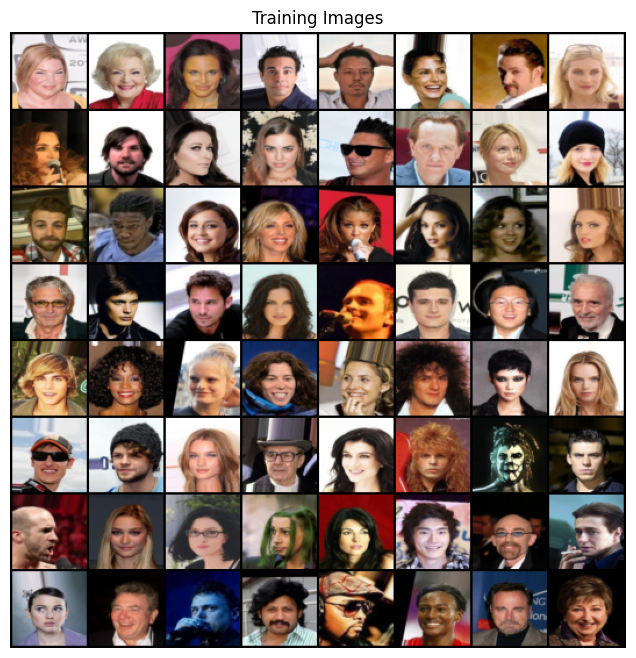

In [84]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [85]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [86]:
class Generator(nn.Module):
    def __init__(self, latent_size, num_channels, img_channels):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.num_channels = num_channels
        self.img_channels = img_channels

        self.net = nn.Sequential(
            self._block(latent_size, 8*num_channels, 4, 1, 0),
            self._block(8*num_channels, 4*num_channels, 4, 2, 1),
            self._block(4*num_channels, 2*num_channels, 4, 2, 1),
            self._block(2*num_channels, num_channels, 4, 2, 1),
            nn.ConvTranspose2d(num_channels, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding, add_norm=True):
        if add_norm:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.ReLU(True),
            )

    def forward(self, x):
        x = self.net(x)
        return x

In [87]:
class Critic(nn.Module):
    def __init__(self, img_channels, num_channels):
        super(Critic, self).__init__()
        self.img_channels = img_channels
        self.num_channels = num_channels

        self.net = nn.Sequential(
            self._block(img_channels, num_channels, 4, 2, 1, False),
            self._block(num_channels, 2*num_channels, 4, 2, 1, True),
            self._block(2*num_channels, 4*num_channels, 4, 2, 1, True),
            self._block(4*num_channels, 8*num_channels, 4, 2, 1, True),
            nn.Conv2d(8*num_channels, 1, kernel_size=1, stride=1, padding=0, bias=False),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding, add_norm=True):
        if add_norm:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, x):
        x = self.net(x)
        # print(x.shape)
        return x

In [88]:
generator = Generator(latent_size, num_channels, img_channels).to(device)
generator.apply(weights_init)
summary(generator, (latent_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [89]:
critic = Critic(img_channels, num_channels).to(device)
critic.apply(weights_init)
summary(critic, (img_channels, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 4, 4]             512
Total params: 2,757,888
Trainable params: 2,757,888
Non-trainable params: 0
---------------------------

In [90]:
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

opt_critic = optim.Adam(critic.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [91]:
def gradient_penalty(critic, real, fake):
    # print(real.shape)
    b, c, h, w = real.shape
    alpha = torch.rand((b, 1, 1, 1)).repeat(1, c, h, w).to(device)

    # calculate interpolated/mean images using random vector alpha and 1-alpha
    interpolated_images = real * alpha + fake * (1 - alpha)

    # calculate critic scores
    mixed_scores = critic(interpolated_images)

    # take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    # reshape gradient to vector, calculate norm
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)

    # calculate gradient penalty
    gp = torch.mean((gradient_norm - 1) ** 2)

    return gp

In [92]:
img_list = []
critic_losses = []
gen_losses = []
iters = 0
start_epoch = 0

total_epochs = sum(epochs_list)
for num_epochs, critic_iter, gen_iter in zip(epochs_list, critic_iters, gen_iters):
    end_epoch = start_epoch + num_epochs
    print(f'start_epoch = {start_epoch}, end_epoch = {end_epoch}, num_epochs = {num_epochs}')
    print(f'critic_iter = {critic_iter}, gen_iter = {gen_iter}')
    for epoch in range(start_epoch, end_epoch):
        for i, data in enumerate(dataloader, 0):

            # get current batch size and batch labels
            b_size = data[0].to(device).size(0)

            for _ in range(critic_iter):
                # reset gradients to zero
                critic.zero_grad()

                # Get critic output on real images
                real_images = data[0].to(device)
                real_output = critic(real_images).reshape(-1)
                # print(real_output.shape)

                # Get critic output on fake images
                noise = torch.randn(b_size, latent_size, 1, 1, device=device)
                fake_images = generator(noise)
                fake_output = critic(fake_images).reshape(-1)
                # print(fake_output.shape)

                # Calculate gradient penalty and critic loss
                gp = gradient_penalty(critic, real_images, fake_images)
                critic_loss = (
                    -(torch.mean(real_output) - torch.mean(fake_output)) + lambda_gp * gp
                )

                # Compute gradients and update Critic
                critic_loss.backward()
                opt_critic.step()

            for _ in range(gen_iter):
                # reset gradients to zero
                generator.zero_grad()

                # Calculate generator loss, compute gradients and update Generator
                fake_images = generator(noise)
                fake_output = critic(fake_images).reshape(-1)
                generator_loss = -torch.mean(fake_output)
                generator_loss.backward()
                opt_generator.step()

                # # generate new noise for next iteration
                noise = torch.randn(b_size, latent_size, 1, 1, device=device)


            if i % 50 == 0:
                print(f"Epoch: [{epoch}/{total_epochs}] Batch: {i}/{len(dataloader)} Loss D: {critic_loss.item()} Loss G: {generator_loss.item()}")

            critic_losses.append(critic_loss.item())
            gen_losses.append(generator_loss.item())

            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = generator(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
    start_epoch = end_epoch

start_epoch = 0, end_epoch = 5, num_epochs = 5
critic_iter = 3, gen_iter = 1
Epoch: [0/5] Batch: 0/1583 Loss D: 0.10349765419960022 Loss G: -0.15612486004829407
Epoch: [0/5] Batch: 50/1583 Loss D: -0.39866283535957336 Loss G: 0.20715248584747314
Epoch: [0/5] Batch: 100/1583 Loss D: -0.18022939562797546 Loss G: 0.16266712546348572
Epoch: [0/5] Batch: 150/1583 Loss D: -0.14876554906368256 Loss G: 0.14080698788166046
Epoch: [0/5] Batch: 200/1583 Loss D: -0.19268879294395447 Loss G: 0.17514190077781677
Epoch: [0/5] Batch: 250/1583 Loss D: -0.20105420053005219 Loss G: 0.22028908133506775
Epoch: [0/5] Batch: 300/1583 Loss D: -0.24476690590381622 Loss G: 0.21631348133087158
Epoch: [0/5] Batch: 350/1583 Loss D: -0.24523822963237762 Loss G: 0.27467772364616394
Epoch: [0/5] Batch: 400/1583 Loss D: -0.23682823777198792 Loss G: 0.3736773431301117
Epoch: [0/5] Batch: 450/1583 Loss D: -0.2121686041355133 Loss G: 0.42208966612815857
Epoch: [0/5] Batch: 500/1583 Loss D: -0.24292892217636108 Loss G: 0.

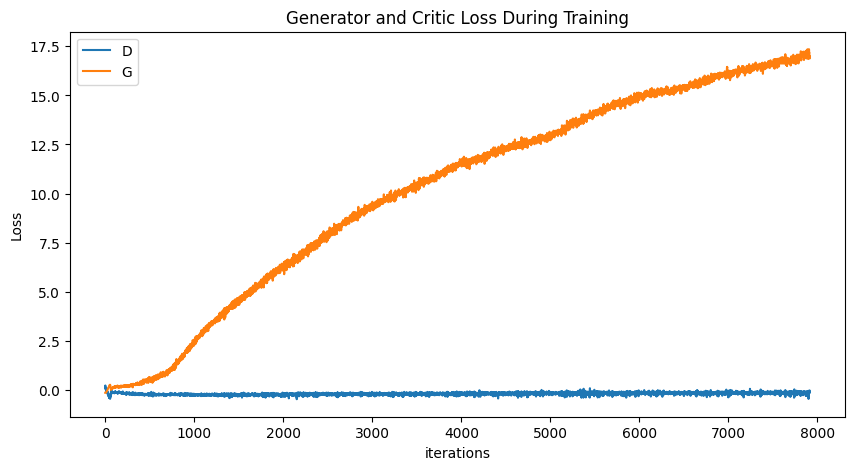

In [98]:
plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training")
plt.plot(critic_losses,label="D")
plt.plot(gen_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

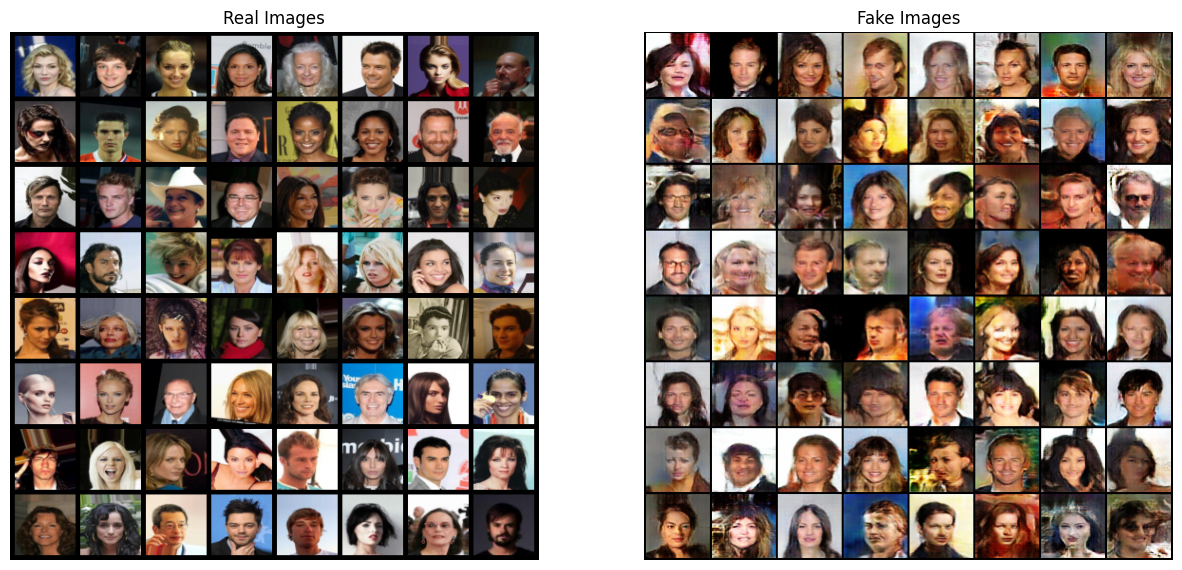

In [94]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [1]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())